# Product Recognition on Store Shelves
## Computer Vision and Image Processing - Exam Project
### Nicholas Antonio Carroll, nicholas.carroll@studio.unibo.it - Laura Mazzuca, laura.mazzuca@studio.unibo.it

## Step A: Multiple Product Detection


### Local Invariant Features Paradigm

Allows to successfully identify objects in scene from a 
single model image per object.

**Four steps**:
1. **Detection**: Identify salient repeatable points (Keypoints) in model and scene images.
2. **Description**: Create a unique description of each point, usually based on its local pixel neighborhood.
3. **Matching**: Match point from scene and model according to a similarity function between the descriptors.
4. **Position Estimation**: Estimate the position of the object in the scene image given enough matching points 

### Environment setup

In [44]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  #Connect to google drive folder, needed only if running notebook on colab
  from google.colab import drive
  drive.mount('/content/gdrive')

In [45]:
if IN_COLAB:
  !pip install opencv-contrib-python==4.5.4.60


In [46]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

if IN_COLAB:
  scenes_location = 'gdrive/MyDrive/shelf-product-recognition/images/scenes/'
  models_location = 'gdrive/MyDrive/shelf-product-recognition/images/models/'
else:
  scenes_location = 'images/scenes/'
  models_location = 'images/models/'

scenes=['e1.png', 'e2.png', 'e3.png', 'e4.png', 'e5.png']
models=['0.jpg','1.jpg','11.jpg','19.jpg','24.jpg','25.jpg','26.jpg']

for i in range(len(scenes)):
  scenes[i] = scenes_location+scenes[i]

for i in range(len(models)):
  models[i] = models_location+models[i]

Load the train images:

In [47]:
img_train = []
for p in scenes:
    img_train.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # trainImage

And all the query images:

In [48]:
img_query = []
for p in models:
    img_query.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # queryImage

### 1. Keypoint Detection
Initialize the SIFT detector object in the following way:


In [49]:
# Initiate SIFT detector
sift = cv2.SIFT_create(nOctaveLayers=5, contrastThreshold=0.11, sigma=1.4) #very good results


Then we need to find keypoints. We will use _detect_ method of the SIFT detector object. Let us find the keypoints of all the query images:

In [50]:
# find the keypoints and descriptors with SIFT
kp_query = []
for img in img_query:
    kp_query.append(sift.detect(img))

Now, let us find and draw the keypoints for the train images:

In [51]:
kp_train = []
for img in img_train:
    kp_train.append(sift.detect(img))

### 2. Keypoints Description 

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support).
We will use the SIFT descriptor.

In [52]:
# Describing keypoints for query and train images
des_query = np.empty(len(img_query), dtype=object)
des_train = np.empty(len(img_train), dtype=object)

for i in range(len(img_query)):
    kp_query[i], des_query[i] = sift.compute(img_query[i], kp_query[i])
for i in range(len(img_train)):
    kp_train[i], des_train[i] = sift.compute(img_train[i], kp_train[i])

### 3. Feature Matching

We will use an approximate kd-tree algorithm from **FLANN** (Fast Library for Approximate Nearest Neighbors) included in OpenCV. 

In [53]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 500)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches_per_image = np.empty(len(img_train), dtype=object)
i = 0 #index for the train images


for des_t in des_train: #for each scene
    matches_per_image[i] = [] #create a list that will hold the matches wrt each model image
    for des_q in des_query: #for each query image
        matches_per_image[i].append(flann.knnMatch(des_q,des_t,k=2)) #compute the matches
    i = i+1

In [54]:
good = np.empty(len(img_train), dtype=object)
i=0
j=0
for mat_img in matches_per_image:#for each list of matches related to an image wrt a train image
    good[i] = np.empty(len(img_query), dtype=object)
    j=0
    for matches in mat_img: # for each list of matches related to the train image j
        good[i][j] = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good[i][j].append(m)
        j=j+1
    i=i+1

### 4. Position Estimation
We can use  **Random Sample Consensus (RANSAC)**, an algorithm to fit a parametric model to noisy data. In our case estimate an homography from good matches while identifying and discarding the wrong ones.

Since images can have different thresholds to be recognized in a scene, the ```check_overlap``` funcion computes the centroid of the bounding box points computed thanks to the homography and if they appear to be overlapping, the one with the most good points gets added to the dst vector, while the other gets removed from it. Then, when a whole scene is scanned, the bounding boxes are finally drawn. It's kind of a naive Non-Maximum Suppression algorithm.

In [55]:
class Box:
    def __init__(self, dst, scene_h, scene_w):
        self.dst = dst
        self.update_corners(scene_h, scene_w)
        self.centre = dst.mean(axis=0)[0]
        self.corners = [(pt[0][0],pt[0][1]) for pt in dst]
        self.h = (self.corners[2][1] + self.corners[1][1] - self.corners[0][1] - self.corners[3][1]) / 2
        self.w = (self.corners[3][0] + self.corners[2][0] - self.corners[1][0] - self.corners[0][0]) / 2
        
    def update_corners(self, scene_h, scene_w):
        i = 0
        #fix point coordinates out of bound
        for pt in self.dst:
            x = pt[0][0]
            y = pt[0][1]
            if x < 0.0:
                x = 0.0
            elif x > scene_w:
                x = scene_w
            if y < 0.0:
                y = 0.0
            elif y > scene_h:
                y = scene_h
            self.dst[i][0]= (x,y)
            i+=1  

In [56]:
def point_distance(pt1, pt2):
    return np.sqrt(np.power(pt1[0]- pt2[0],2) + np.power(pt1[1] - pt2[1],2))

In [57]:
def check_points_closeness(pt1, pt2, th):
    return point_distance(pt1, pt2) <= th

In [58]:
def check_overlap(dst, j, th):
    if j == 0:
        return -1
    
    for img in range(j):
        if dst[img] is not None:            
            if check_points_closeness(dst[j].centre, dst[img].centre, th):
                return img
    return -1

scene 0

Product 0 - 1 instances found.
	Instance 1 in 163.05, 216.01), width: 310px, height: 430px 
Product 1 - 1 instances found.
	Instance 1 in 444.93, 179.23), width: 296px, height: 358px 
Product 2 - 0 instances found.
Product 3 - 0 instances found.
Product 4 - 0 instances found.
Product 5 - 0 instances found.
Product 6 - 0 instances found.


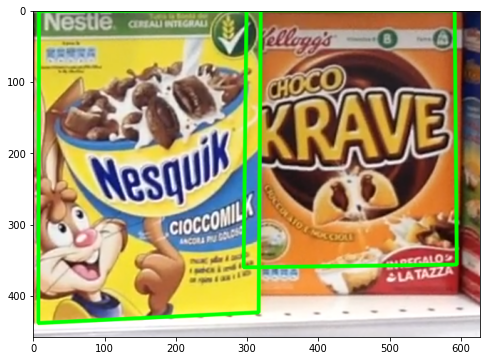



scene 1

Product 0 - 0 instances found.
Product 1 - 0 instances found.
Product 2 - 0 instances found.
Product 3 - 0 instances found.
Product 4 - 1 instances found.
	Instance 1 in 168.21, 232.65), width: 334px, height: 465px 
Product 5 - 1 instances found.
	Instance 1 in 878.54, 233.78), width: 313px, height: 444px 
Product 6 - 1 instances found.
	Instance 1 in 538.21, 230.90), width: 333px, height: 462px 


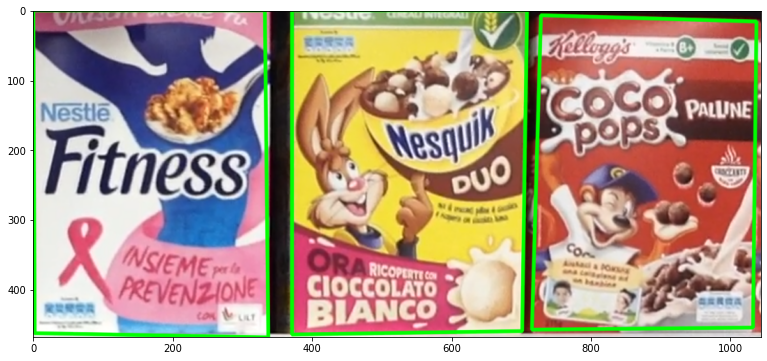



scene 2

Product 0 - 1 instances found.
	Instance 1 in 170.99, 233.54), width: 325px, height: 434px 
Product 1 - 1 instances found.
	Instance 1 in 809.46, 198.60), width: 296px, height: 390px 
Product 2 - 1 instances found.
	Instance 1 in 475.82, 191.69), width: 302px, height: 383px 
Product 3 - 0 instances found.
Product 4 - 0 instances found.
Product 5 - 0 instances found.
Product 6 - 0 instances found.


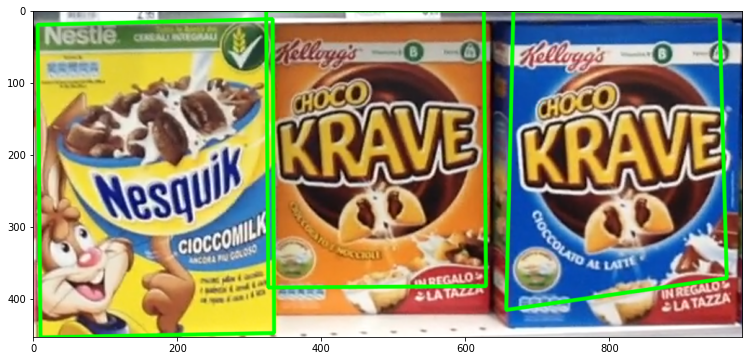



scene 3

Product 0 - 1 instances found.
	Instance 1 in 160.75, 736.43), width: 322px, height: 434px 
Product 1 - 1 instances found.
	Instance 1 in 464.56, 688.77), width: 299px, height: 390px 
Product 2 - 0 instances found.
Product 3 - 0 instances found.
Product 4 - 0 instances found.
Product 5 - 1 instances found.
	Instance 1 in 553.55, 218.77), width: 321px, height: 438px 
Product 6 - 1 instances found.
	Instance 1 in 205.73, 221.16), width: 341px, height: 442px 


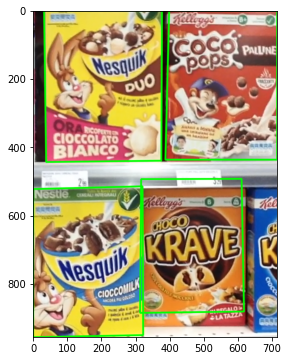



scene 4

Product 0 - 0 instances found.
Product 1 - 0 instances found.
Product 2 - 0 instances found.
Product 3 - 1 instances found.
	Instance 1 in 504.26, 191.64), width: 295px, height: 383px 
Product 4 - 0 instances found.
Product 5 - 1 instances found.
	Instance 1 in 162.29, 229.23), width: 319px, height: 448px 
Product 6 - 0 instances found.


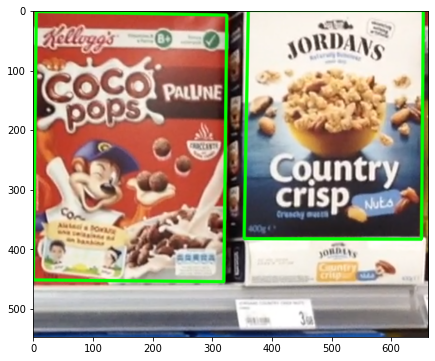

In [61]:
# Checking if we found enough matching
img_train_rgb = []
for p in scenes:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage

MIN_MATCH_COUNT = 80
OVERLAP_TH = 15.0
matchesMask = np.empty(len(img_train), dtype=object)
dst = np.empty(len(img_train), dtype=object)
color = (0, 255, 0)

for i in range(len(img_train)):
    print("scene {}\n".format(i))
    cur_kp_train = kp_train[i]
    matchesMask[i] = np.empty(len(img_query), dtype=object)
    dst[i] = np.empty(len(img_query), dtype=object)
    for j in range(len(img_query)):
        if len(good[i][j])>MIN_MATCH_COUNT:
            cur_kp_query = kp_query[j]
            # building the corrspondences arrays of good matches
            src_pts = np.float32([ cur_kp_query[m.queryIdx].pt for m in good[i][j] ]).reshape(-1,1,2)
            dst_pts = np.float32([ cur_kp_train[m.trainIdx].pt for m in good[i][j] ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Mask of discarded point used in visualization
            matchesMask[i][j] = mask.ravel().tolist()
            # Corners of the query image
            h,w = img_query[j].shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst[i][j] = Box(cv2.perspectiveTransform(pts,M), img_train[i].shape[0], img_train[i].shape[1])
            
            overlap_idx = check_overlap(dst[i], j, OVERLAP_TH)
            if overlap_idx > -1:
                if len(good[i][j]) >= len(good[i][overlap_idx]):
                    dst[i][overlap_idx] = None
                else:
                    dst[i][j] = None         
        else:
            #print( "Not enough matches are found - {}/{}".format(len(good[i][j]), MIN_MATCH_COUNT) )
            matchesMask[i][j] = None
            
    for j in range(len(img_query)):
        if dst[i][j] is not None:
            print('Product {} - {} instances found.'.format(j, 1))
            # Drawing the bounding box
            cur_box = dst[i][j]
            img_train_rgb[i] = cv2.polylines(img_train_rgb[i],[np.int32(dst[i][j].dst)],True,color,3, cv2.LINE_AA)
            print(f'\tInstance 1 in {cur_box.centre[0]:.2f}, { cur_box.centre[1]:.2f}), width: {cur_box.w:.0f}px, height: {cur_box.h:.0f}px ')
        else:
            print('Product {} - {} instances found.'.format(j, 0))
    plt.figure(figsize = (40,6))
    plt.imshow(img_train_rgb[i])
    plt.show()
    print("\n")

Finally, if we want to draw the matches we can do it in the following way:

scene 0



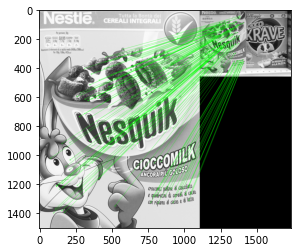

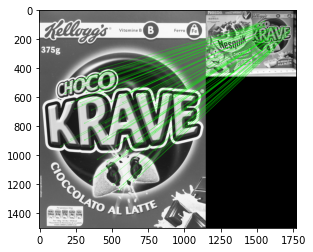

scene 1



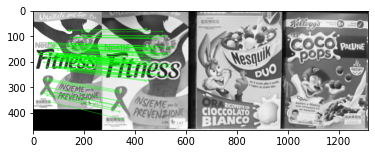

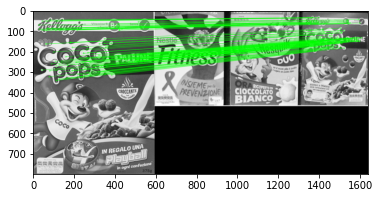

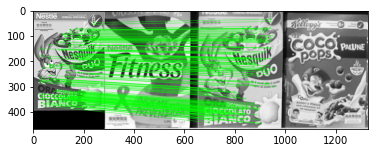

scene 2



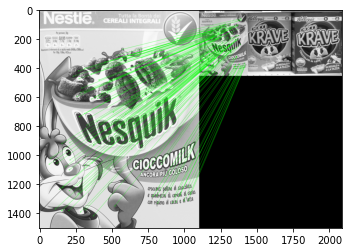

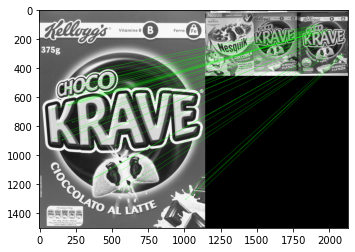

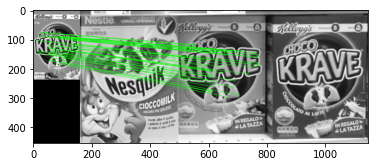

scene 3



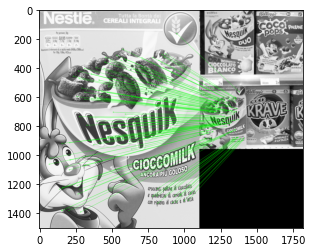

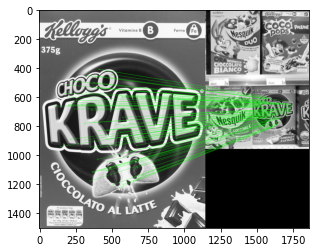

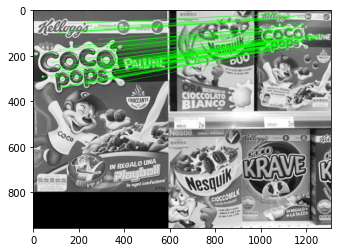

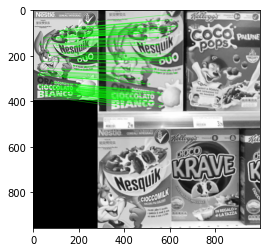

scene 4



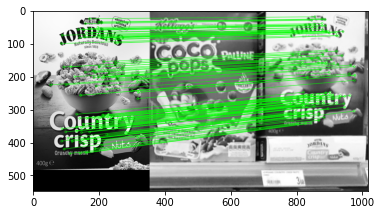

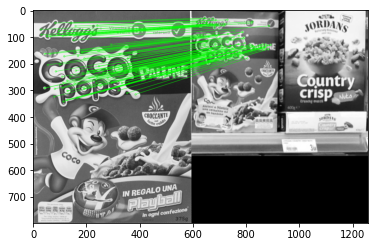

In [63]:
# Drawing the matches
for i in range(len(img_train)):
    print("scene {}\n".format(i))
    for j in range(len(img_query)):
        if dst[i][j] is not None:
            draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask[i][j], # draw only inliers
                   flags = 2) # not draw keypoints only lines
            img3 = cv2.drawMatches(img_query[j],kp_query[j],img_train[i],kp_train[i],good[i][j],None,**draw_params)
            plt.imshow(img3, 'gray')
            plt.show()